# Visualisation of electric current spectra (Gabor transform) and Electron photoemission spectra obtained by *cntr* code

### Warning: material-specific code, use only for La<sub>2</sub>CuO<sub>4</sub>, implicit energy and time renormalization 0.43, based on compound bandwidth is used. Only *x* field projection is read from the current file, i.e. the value of current is multiplied by sqrt(2) for the [110] polarization


#### File name: **gt.py** 
#### Input:
- Electric current versus time **j.out**, output of *cntr* code
  - Energy/time renormalization is **0.43** (hard-coded, material-specific for La<sub>2</sub>CuO<sub>4</sub> due to material bandwidth)
- Electric field profile **Pulse_xy.dat**, output of *cntr* code
  - Only *x* field projection is read from the current file, i.e. the value of field strength is multiplied by sqrt(2) for the [110] polarization
  
#### Output:
 - The **Jxy.png** file. 
  - The upper panel shows electric field profile and electric current
  - The middle panel shows electric current spectra vs time
  - The lower panel shows spectra of electric field (averaged) and electric current (averaged, and at two certain times)
 - **x.dat**, **y.dat** files: values of time and current used as an input for **FFT** 
 - **xf.dat**, **yf.dat** files: values of frequency and current of the **FFT** result
### Code

#### Loading libraries:

In [2]:
import numpy as np
from   fractions import Fraction
import matplotlib.pyplot as plt
import matplotlib.colors as collors
from   matplotlib.colors import LogNorm
import matplotlib.cm as cmx
import scipy.signal
import sys
import glob
import re
import math

from numpy import sin, linspace, pi
from pylab import plot, show, title, xlabel, ylabel, subplot
from scipy import fft, arange
from matplotlib.collections import PolyCollection
from matplotlib import ticker

#### Setting calculation parameters:

In [3]:
FourLn2=4.0*np.log(2.0)

##############  defining arrays  #############
timeFS = np.array([])
Current_fs = np.array([])
E_field = np.array([])

#PARAMETERS for Fourier transform:
MaxFreq2D=3

#PARAMETERS for Gabor transform:
wPlotMax=16
tick_spacingW = 2.0
# tick step in W (eV)
tick_spacingT = 2
# tick step in t (fs) 
# wPlotMax, tick_spacing in eV for Gabor 3D plot

# Desired width of Gabor slice in fs (will be slightly adjusted, see GaborSliceWidth)
GaborSliceWidth=0.5

# Width of Gabor Gaussian FWHM in fs
GaborFWHM=8.0

# value from previous version (was hard-coded there):
#GaborFWHM=2*np.sqrt((GaborSliceWidth**2)*FourLn2)

###################### Not used: command line input parameters  ###################
#if (len(sys.argv)!=2): sys.exit('need Energy/time renormalization parameter: how much eV is in this runs energy unit???')
#renorm=float(sys.argv[1])

#LCO-XY-Linear-polarization-specific script !!!!!!!!!!!!!!!!!!!!!!!!
renorm=0.43
#############  script for LCO, a0 is in-plane lattice constant  !!!!!!!!!!
a_0=3.78e-10 
# one E component only available in control and pulse files,
# should be read and multiplied by Efactor=sqrt(2) 
Efactor=np.sqrt(2)

#### Reading input files:

In [4]:
############# input parameters from control input file inp*   ############
inpFiles = glob.glob('./inp*')
if (len(inpFiles)!=1):
	sys.exit('Problem with input files (too few or too many)')
	
with open(inpFiles[0]) as file:
    inpp = file.read()
inpVals = re.findall(r'(\_+\w+)=(.+)', inpp)
inpDict = dict(inpVals)

### distance between consequent time points from input files in fs
spacing = float(inpDict["__h"])*0.66/renorm

### pulse central frequency in eV
omega_eV= float(inpDict["__omega"])*renorm

### Coulomb repulsion in eV
U_eV= float(inpDict["__U"])*renorm

### Maximal electric field strength of pulse envelope in V/m
EmaxVM= float(inpDict["__E"])*Efactor*omega_eV/a_0

############### reading files and converting data to the proper units  ##########################
### Current and time:
dataCurrent=np.genfromtxt('j.out', skip_header=0)
timeFS=dataCurrent[:,0]*spacing	 
Current_fs=dataCurrent[:,1]*renorm*Efactor

dataAxy=np.genfromtxt('Pulse_xy.dat', skip_header=2)
E_field=-np.gradient(dataAxy[:,1],spacing)*Efactor
Axy=dataAxy[:,1]*Efactor

##### read PES data
dataPES=np.genfromtxt('Spectr_PES.out')

#### Performing Gabor transform:

In [5]:
# Number of sample points
Nt=len(Current_fs)
Ns=np.int(Nt*spacing/(GaborSliceWidth))

# new Gabor Width, in order to maintain integer number of slices
GaborSliceWidth=Nt*spacing/Ns

Current_eV = np.abs(fft(Current_fs))
A_eV = fft(Axy)

#xf =  np.linspace(0.0, N/2, N)
#Given sampling rate FSample and transform blocksize N, you can calculate 
#the frequency resolution deltaF, sampling interval deltaT, 
#and total capture time capT using the relationships:
#
#deltaT = 1/FSample = capT/N
#deltaF = 1/capT = FSample/N
#Keep in mind also that the FFT returns value from 0 to FSample, 
#or equivalently -FSample/2 to FSample/2. 
#In your plot, you're already dropping the -FSample/2 to 0 part
#
# From StackOverflow

FreqStep=4.13/(Nt*spacing)
wmax=0.5*Nt*FreqStep
xf =  np.linspace(0.0, wmax, Nt//2)

# preparing an array of Gaussian enveloped current with stepwise shifted window
EnvelopedCurrent_fs=[[Current_fs[j]*np.exp(-((j*spacing)-i*GaborSliceWidth)**2/((GaborFWHM**2)/(FourLn2))) for j in range(0,Nt)] for i in range(0,Ns)]

# making FFT and dropping negative frequencies (at the second half of vector)
GaborCurrent_eV=[np.abs(fft(np.asarray(EnvelopedCurrent_fs[i])))[0:Nt//2] for i in range(0,Ns)]

#### Making three-panel plot:

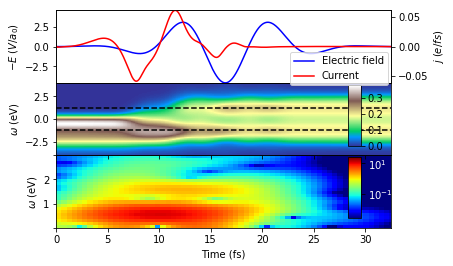

In [18]:
fig = plt.figure()
gridspace_fs = plt.GridSpec(3, 1, hspace=0)
#gridspace_eV = plt.GridSpec(4, 1, hspace=0.8)
axs0 = fig.add_subplot(gridspace_fs[0,:])
axs1 = fig.add_subplot(gridspace_fs[2,:])
axs2 = fig.add_subplot(gridspace_fs[1,:])
#axs3 = fig.add_subplot(gridspace_eV[3,:])


maxE=max(np.abs(E_field))
maxJ=max(np.abs(Current_fs))
axs0.set_ylim(-maxE, maxE)
#axs0.set_xlim(0,(Ns+1)*WG/2.0)
axs0a = axs0.twinx()
axs0a.set_ylim(-maxJ, maxJ)

#.xlim(0, gtLong[-1,0]*GaborSliceWidth)
#omMaxPlot=math.trunc(gt[-1,1]*renorm)-0.001
#.ylim(-omMaxPlot,omMaxPlot)
axs0.set_xlim(0,32.5)
axs1.set_xlim(0,32.5)
axs2.set_xlim(0,32.5)
axs1.set_ylim(0,3)

#axs0.plot(timeFS, Axy, label="Vector potential")
plotE, = axs0.plot(timeFS, -E_field, label="Electric field", color='b')
plotJ, = axs0a.plot(timeFS, Current_fs, label="Current", color='r')
axs0.set_ylabel(r'$-E$ $(V/a_0)$')
axs0a.set_ylabel(r'$j$ $(e/fs)$')
plt.figlegend((plotE, plotJ), ('Electric field', 'Current'), bbox_to_anchor=[0.91, 0.76], loc='upper right')
plt.setp(axs0.get_yticklabels()[0], visible=False)
plt.setp(axs0a.get_yticklabels()[0], visible=False)
plt.setp(axs0.get_xticklabels(), visible=False)
plt.setp(axs0a.get_xticklabels(), visible=False)


# making a generator, giving us four (x,y) tuples of rectangle vertices coordinates:
rectVertexes = (((0+i,0+k),(0+i,FreqStep+k+0.05),(GaborSliceWidth+i+0.05,FreqStep+k+0.05),(GaborSliceWidth+i+0.05,0+k)) for i in np.arange(0, GaborSliceWidth*Ns, GaborSliceWidth) for k in (np.arange(0, FreqStep*(Nt//2), FreqStep)))

# making a polygon collection, using quadruples of (x,y) tupples as vertexes, and GaborCurrent_eV as a color
colll = PolyCollection(rectVertexes, array=np.array(GaborCurrent_eV).reshape(Ns*(Nt//2)), linewidths=0, alpha=1.0, norm = LogNorm(vmin=0.003, vmax=25), cmap=cmx.jet)

# adding the collection to the axis
axs1.add_collection(colll)

cbaxes1 = fig.add_axes([0.80, 0.16, 0.03, 0.21]) 
cb1 = plt.colorbar(colll, cax = cbaxes1)  
cbytick_obj1 = plt.getp(cb1.ax.axes, 'yticklabels')
plt.setp(cbytick_obj1, color='w')

plt.setp(axs1.get_yticklabels()[0], visible=False)
plt.setp(axs1.get_yticklabels()[-1], visible=False)
axs1.set_xlabel('Time (fs)')

cm = plt.get_cmap("terrain")
cNorm = collors.Normalize(vmin=min(dataPES[:,2]), vmax=max(dataPES[:,2]))
scc=axs2.scatter(dataPES[:,0]*spacing,dataPES[:,1]*renorm, s=2, c=dataPES[:,2], cmap=cm, marker="s", linewidth=0)  
axs2.set_ylabel(r'$\omega$ (eV)')
#axs2.set_xlim(0,dataPES[-1,0]*spacing-TimeZero)
omMaxPlot=math.trunc(dataPES[-1,1]*renorm)-0.001
axs2.set_ylim(-omMaxPlot,omMaxPlot)
plt.setp(axs2.get_yticklabels()[0], visible=False)
plt.setp(axs2.get_yticklabels()[-1], visible=False)
axs2.axhline(y=(-U_eV/2.0), color='k', linestyle='--')
axs2.axhline(y=(U_eV/2.0), color='k', linestyle='--')

cbaxes2 = fig.add_axes([0.80, 0.41, 0.03, 0.21]) 
cb2 = plt.colorbar(scc, cax = cbaxes2)  
tick_locator = ticker.MaxNLocator(nbins=4)
cb2.locator = tick_locator
cb2.update_ticks()

axs1.set_ylabel(r'$\omega$ (eV)')
#axs2.set_xlabel('Time (fs)')
axs2.set_ylabel(r'$\omega$ (eV)')
plt.setp(axs1.get_yticklabels()[-1], visible=False)
plt.setp(axs2.get_xticklabels(), visible=False)

########## lowest panel with overall current spectra and Gabor spectra at selected times 
#
#axs3.set_xlim(0,MaxFreq2D)
#axs3.plot(xf, 2.0/Nt * np.abs(A_eV[0:Nt//2]), label="Vector potential, FT")
#axs3.plot(xf, PrefactorJF*2.0/Nt * Current_eV[0:Nt//2], label="Current, FT")
#axs3.plot(xf, 2*PrefactorJF*2.0/Nt * GaborCurrent_eV[1][0:Nt//2], label="Current, xfs")
#axs3.plot(xf, 4*PrefactorJF*2.0/Nt * GaborCurrent_eV[2][0:Nt//2], label="Current, yfs")
#axs3.legend(bbox_to_anchor=(0.65, 1.4), loc='upper left', borderaxespad=0)
#axs3.set_xlabel(r'$\omega$ (eV)')
#axs3.set_ylabel('FT')

plt.show()

#plt.savefig("HHGw04lco8e9u25.png")